In [1]:
!pip install gymnasium
!pip install pyglet
!pip install pygame

Episode 0 | Score: 9.0 | 9 steps | 0.93s.
Episode 1 | Score: 9.0 | 9 steps | 1.01s.
Episode 2 | Score: 9.0 | 9 steps | 1.00s.
Episode 3 | Score: 9.0 | 9 steps | 1.01s.
Episode 4 | Score: 9.0 | 9 steps | 1.01s.
Episode 5 | Score: 10.0 | 10 steps | 1.10s.
Episode 6 | Score: 10.0 | 10 steps | 1.11s.
Episode 7 | Score: 9.0 | 9 steps | 1.00s.
Episode 8 | Score: 11.0 | 11 steps | 1.20s.
Episode 9 | Score: 24.0 | 24 steps | 2.51s.
Episode 10 | Score: 100.0 | 100 steps | 10.15s.
Episode 11 | Score: 53.0 | 53 steps | 5.43s.
Episode 12 | Score: 77.0 | 77 steps | 7.84s.
Episode 13 | Score: 17.0 | 17 steps | 1.81s.
Average Score for  14  episodes is: 25.428571428571427


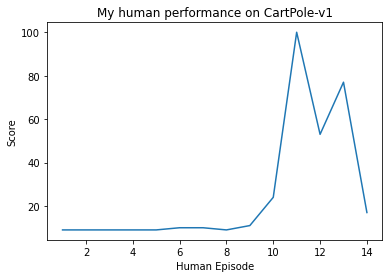

In [11]:
#This is the mannual game play cell
import gymnasium as gym
from gym.envs.classic_control.cartpole import *
from pyglet.window import key
import matplotlib.pyplot as plt
import time
from gymnasium.utils.play import play

bool_do_not_quit = True  # Boolean to quit pyglet
scores = []  # Your gaming score
a = 0  # Action
total_reward = 0
episode = 1
steps = 0
start_time = time.time()

def cartpole_callback(obs, q_obs, action, reward, terminated, truncated, info):
    global total_reward, steps, start_time
    total_reward += reward
    steps += 1
    if terminated or truncated:
        print("Episode", len(scores), "| Score:", total_reward, '|', steps, "steps | %0.2fs."% (time.time()-start_time))
        scores.append(total_reward)
        total_reward = 0
        steps = 0
        start_time = time.time()
    
    
    
def run_cartPole_asHuman(policy=None):
    env = gym.make('CartPole-v1', render_mode="rgb_array")
    env.reset()
    play(env, keys_to_action={"a":0, "d":1}, callback=cartpole_callback, fps=10)



run_cartPole_asHuman() 

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import statistics
print("Average Score for ", len(scores), " episodes is:",statistics.mean(scores))
# Plot your score
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.title('My human performance on CartPole-v1')
plt.ylabel('Score')
plt.xlabel('Human Episode')
plt.show()

In [3]:
import gym
from gym.envs.classic_control.cartpole import *
from pyglet.window import key
import matplotlib.pyplot as plt
import time


bool_do_not_quit = True  # Boolean to quit pyglet
scores = []  # Your gaming score
a = 0  # Action
#env = gym.make('CartPole-v1', render_mode="human") #display
env = gym.make('CartPole-v1') #headless

number_of_trials = 500

def dummy_policy(state=0):
    a = env.action_space.sample()
    return a



import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,BatchNormalization,Activation
from tensorflow.keras.callbacks import ModelCheckpoint
import datetime,os
import collections
import random
import copy

def build_model():
    inputs = keras.Input(shape=(4,))
    x = layers.Dense(32,activation='tanh')(inputs)
    x = layers.Dense(64,activation='tanh')(x)

    outputs = layers.Dense(2, activation="linear")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="dqn_model")
    #lr stands for learning rate
    optimizer = keras.optimizers.Adam(lr=0.001)

    model.compile(
        optimizer =optimizer,loss='mse',
    )
    return model

model= build_model()
target_network = build_model()
gamma = 0.95

epsilon = 1.0/number_of_trials

episode_reward_list = []     
exploring_rate=0.0
target_score = 200

memory = collections.deque(maxlen=100000)
batch_size=32
max_reward = -10000
target_update_steps = 20


steps_to_target = 20
done=False

last_state = []
a = []
reward = 0
total_reward = 0.0



#Get the predictd best action by our network
def deep_q_policy(state):
    
    #print("state: ", state)
    # Get the model's reward estimations of each Q(s,a)
    #action_q_values = model.predict([[state[0],state[1],state[2],state[3]]])
    #x = tf.random.uniform((1,4)) # working random - REPLACE (DEBUG)
    x=None
    try:
        x = tf.constant([[state[0], state[1], state[2], state[3]]])
    except:
        x = tf.constant([state[0]])
    #print(x)
    action_q_values = model.predict(x)
    
    # If exploiting, choose the model's estimated best action 
    return np.argmax(action_q_values)



#Change our exploring rate so that later rounds are less random later on (because our network will hopefully be improving)
def update_exploring_rate(roundNumber):
    global exploring_rate
    exploring_rate = 1-roundNumber*epsilon 
    if exploring_rate<0:
        exploring_rate = 0.01


        
# Feed our network the batch of state changes and rewards
def experience_replay():
    global memory
    state_batch, q_batch = [], []
    # Get a batch of random state changes from memory to train our network
    minibatch = random.sample(memory, min(len(memory), batch_size))
    for m_state, m_action, m_reward, m_next_state, m_done in minibatch:
        if len(m_state) > 0:
            #print("m_state: ", m_state)
            #m_q_values = model.predict([[m_state[0],m_state[1],m_state[2],m_state[3]]])
            #x = tf.random.uniform((1,4)) # working random - REPLACE (DEBUG)
            x=None
            try:
                x = tf.constant([[m_state[0], m_state[1], m_state[2], m_state[3]]])
            except:
                x = tf.constant([m_state[0]])
            #print(x)
            m_q_values = model.predict(x)
            #How good is this action?
            if m_done :
                m_q_values[0][m_action] = m_reward
            else:
                #x = tf.constant([m_next_state])
                #q_x = tf.random.uniform((1,4)) # working random - REPLACE (DEBUG)
                q_x = tf.constant([[m_next_state[0],m_next_state[1], m_next_state[2], m_next_state[3]]])
                #m_q_values[0][m_action] = m_reward + gamma * np.max(target_network.predict([[m_next_state[0],m_next_state[1], m_next_state[2], m_next_state[3]]])[0])
                m_q_values[0][m_action] = m_reward + gamma * np.max(target_network.predict(q_x)[0])
                
            #Add to the list of states
            #state_batch.append([m_state[0],m_state[1],m_state[2],m_state[3]])
            state_batch.append(x[0])
            
            #Add to the list of q values
            q_batch.append(m_q_values[0])
    
    # Train on the batch
    loss = model.train_on_batch(np.array(state_batch),np.array(q_batch))
    
    return loss


#Evaluate our model and, if it is better than the previous best, save the new weights
def update_scores():
    global max_reward
    round_reward = scores[len(scores)-1]
    if round_reward >= max_reward:
        model.save("./dqn_exp_replay_tgtnetwork.h5")
        max_reward = round_reward
    scores.append(round_reward)
    episode_reward_list.append(round_reward)


    
#Update the target network
def update_target():
    global steps_to_target
    # Update target network if it is time 
    if steps_to_target<=0:
        target_network.set_weights(model.get_weights())
        steps_to_target = target_update_steps
    # Otherwise count down
    else:
        steps_to_target-=1
    
    

    
#Deep q-learning algorithm using experience replay and a target network
def dql_with_experience_replay_target(state):
    global exploring_rate
    global epsilon
    global memory
    global done
    global reward
    
    # Update the exploring rate for the first round and 
    if done or len(scores) <= 0:
        update_exploring_rate(len(scores)+1)
        #print(exploring_rate*100, "% random")
    
    # Update scores and target after each round
    if done:
        update_target()
        update_scores()
        loss = experience_replay()
    
    # Add each state change and its reward to memory for experience replay
    if len(last_state) >= 0:
        memory.append((last_state, a, reward, state, done))
    
    # Decide whether we should explore or exploit
    exploring =  np.random.choice([True,False], p=[exploring_rate,1-exploring_rate])
            
    
    if exploring: # Exploration
        action = env.action_space.sample() # Random action
    else: # Exploitation
        action = deep_q_policy(state) # Estimated best action
        
    
    return action
    


def run_cartPole_asAgent(policy, num_runs=1):
    global last_state
    global a
    global reward
    global done
    
    env.reset()
    env.render()

    for _ in range(num_runs):
        state = env.reset()
        total_reward = 0.0
        steps = 0
        restart = False
        t1 = time.time()  # Trial timer
        while bool_do_not_quit:
            #this is where policy function outputs action a based on the current state
            a = policy(state)
            last_state = copy.copy(state)
            #this is there you get the next system state after take action a
            state, reward, done, truncated, info = env.step(a)
            #time.sleep(1/10)  # 10fps: Super slow for us poor little human!
            total_reward += reward
            steps += 1
            env.render()
            if done or restart or truncated:
                t1 = time.time()-t1
                scores.append(total_reward)
                print("Episode", len(scores), "| Score:", total_reward, '|', steps, "steps | %0.2fs."% t1)
                break
    env.close()


run_cartPole_asAgent(dql_with_experience_replay_target, number_of_trials)  # Run with agent input


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import statistics
print("Average Score for ", number_of_trials, " episodes is:",statistics.mean(scores))
# Plot your score
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.title('My agent performance on CartPole-v1')
plt.ylabel('Score')
plt.xlabel('Agent Episode')
plt.show()


C:\Users\leigh\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
C:\Users\leigh\anaconda3\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1 | Score: 10.0 | 10 steps | 0.00s.
Episode 3 | Score: 37.0 | 37 steps | 0.77s.
Episode 5 | Score: 41.0 | 41 steps | 1.84s.
Episode 7 | Score: 31.0 | 31 steps | 1.96s.
Episode 9 | Score: 12.0 | 12 steps | 1.85s.
Episode 11 | Score: 21.0 | 21 steps | 1.69s.
Episode 13 | Score: 16.0 | 16 steps | 1.74s.


KeyboardInterrupt: 

Episode 15 | Score: 500.0 | 500 steps | 14.12s.


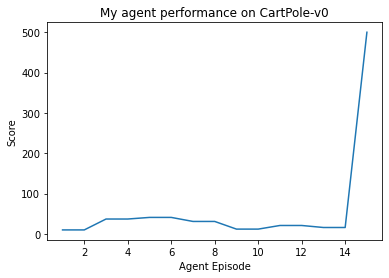

In [4]:
#Set the best agent off playing

def play_best():
    model.load_weights("./best_dqn.h5")
    run_cartPole_asAgent(deep_q_policy)

play_best()

# Plot your score
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.title('My agent performance on CartPole-v0')
plt.ylabel('Score')
plt.xlabel('Agent Episode')
plt.show()